## Machine Learning for Computer Vision SoSe 2022

### Praktikum 4

Content Based Image Retrieval mit primitiven Merkmalen

Bauen Sie ein einfaches System zur inhaltsbasierten Bildsuche, basierend auf Farbmerkmalen. Verwenden
Sie dazu die in FELIX bereitgestellte Mini-Bilddatenbank wangCustom10 (1000 Bilder). Sie können das System später ggf. auf Ihre
eigenen Bildsammlungen anwenden. 

In [24]:
from skimage import io, util
from skimage.color import rgb2hsv, rgb2gray
import sklearn.metrics
import skimage.feature
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import glob
import json
import math


Entpacken Sie die bereitgestellte Bildersammlung in einen Ordner relativ zu diesem Notebook, so dass Sie im weitern Verlauf der Übung auf die Bilder zum Anzeigen und zum Berechnen von Merkmalen zugreifen können.

Um später einfach auf die Files im Verzeichnis zugreifen zu können, wird im folgenden eine Funktion bereitgestellt, die die Liste der Bilder aus einer Text-Datei ausliest, ggf. mit einem (relativen) Pfad ergänzt und die Liste der Bilder zurückgibt. 


In [25]:
def get_all_files(dirName: str):
    ''' Get All Images Inside DirName '''
    return glob.glob(os.path.join(dirName,"*","*.jpg"))

#### Erstellung von HSV-Farbhistogrammen
Schreiben Sie eine Funktion, die von einem Bild ein globales HSV-Farbhistogramm als Merkmal berechnet. Als Eingabeparameter soll dabei der Dateiname dienen. Als Rückgabewert soll die Funktion einen
numpy-Vektor erzeugen. Wählen Sie eine geeignete Quantisierung für das Histogramm.

http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2hsv

https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogramdd.html


In [26]:
def get_image_data(image: any):
    ''' Loads Image From File And Returns Image Data'''
    if isinstance(image, str):
        return io.imread(image)
    elif isinstance(image, np.ndarray):
        return image

In [27]:
def calculate_histogram_from_image(image: any) -> tuple:
    '''Calculates the Histogram From Image File Or Image Data'''
    input_image = get_image_data(image)
    
    hsv_Image = rgb2hsv(input_image)
    hsv_Image = hsv_Image.reshape(-1, 3)
    
    #histo, _ = np.histogramdd(hsv_Image, bins=(5,3,3))
    histo, _ = np.histogramdd(hsv_Image, bins=(10,6,6))
    histo.flatten()
    histo = histo / np.sum(histo)
    return histo

#### Histogramm Intersection zur Ähnlichkeitsbestimmung
Implementieren Sie eine Funktion, die zwei Merkmalsvektoren entgegennimmt und als Ähnlichkeitsmaß
den Histogram-Intersection Wert zurückgibt.

In [28]:
def histogram_intersection(histogram_1: any, histogram_2:any):
    ''' Calculates The Histogram Intersection From Two Histograms '''
    return np.sum(np.minimum(histogram_1,histogram_2))

# histogram_intersection(calculate_histogram_from_image(get_all_files("wangCustom10")[785]), calculate_histogram_from_image(get_all_files("wangCustom10")[785]))

#### Datenbank erstellung

##### Achtung

Hier wird eine ca. 10 MB große Datenbank erstellt, was mehrere Sekunden dauert. Es muss eine Datenbank existieren damit keine Fehler auftreten.
Um eine Datenbank zu erstellen, muss

    create_image_feature_db("wangCustom10", os.path.join(".","featureDb.json"))

ausgeführt werden

In [29]:
def create_image_feature_db(imageDirName: str, dbPathName: str) -> None:
    ''' Creates A JSON File Containing All Data And Features About The Images Inside imageDirName '''
    jsonList = {"Categories":{}, "Images":[]}
    categoryList = []
    for file in get_all_files(imageDirName):
        cat:str = file.split(os.path.sep)[-2]
        name:str = file.split(os.path.sep)[-1]
        image_set = {"Path": file, "Category": cat, "Filename": name, "Histogram": calculate_histogram_from_image(file).tolist()}
        jsonList["Images"].append(image_set)
        
        if cat in jsonList["Categories"].keys():
            counter = jsonList["Categories"][cat]
            jsonList["Categories"][cat] = counter + 1
        else:
            jsonList["Categories"][cat] = 1
            
    
    with open(dbPathName, "w", encoding='utf-8') as file:
        json.dump(jsonList, file, separators=(',', ':'), indent=2)
    
# create_image_feature_db("wangCustom10", os.path.join(".","featureDb.json"))

In [30]:
def load_feature_db(fileName: str) -> dict:
    ''' Reads A Generated JSON File And Returns A Dict Containing All Data '''
    with open(fileName, "r", encoding='utf-8') as file:
        jsonData = json.load(file)
        for data in jsonData["Images"]:
            data["Histogram"] = np.array(data["Histogram"])
            
        return jsonData
    
dbData = load_feature_db(os.path.join(".","featureDb.json"))

In [31]:
def get_database_data(dbdata):
    if isinstance(dbData, str):
        return load_feature_db(dbData)
    elif isinstance(dbData, dict): 
        return dbData

#### Ähnlichste Bilder bestimmen
Erstellen Sie eine Funktion, die für ein Anfragebild die Ähnlickeiten zu allen Bildern in der DB berechnet
(mit Hilfe der Histogram Intersection). Die Ähnlichkeiten sollen als 1D np-Array zurückgegeben werden.

In [32]:
def search_imge(image: any, db_data: any, result_size: int = 10):
    ''' Searches For A Image Using Histogram Intersection And A Image Database. '''
    database = get_database_data(db_data)
    input_image = get_image_data(image)
        
    all_results = {"Input": input_image, "Results": []}
    searched_histo = calculate_histogram_from_image(input_image)
    
    for data in database["Images"]:
        data_set = {"Path": data["Path"], "Category": data["Category"], "Filename": data["Filename"], "Result": histogram_intersection(searched_histo, data["Histogram"])}
        all_results["Results"].append(data_set)
        
    def sort_by_result(e: dict):
        return e["Result"]
    
    all_results["Results"].sort(reverse=True, key=sort_by_result)
    all_results["Results"] = all_results["Results"][0:result_size]
    return all_results
 

#### Visualisierung Ergebnisse
Suchen Sie nun ein Anfragebild aus (kann in der vorgegebenen Sammlung enthalten sein). Zu diesem Anfragebild sollen nun die 10 ähnlichsten Bilder (bzüglich den oben erstellten Merkmalen und HI) gefunden werden.

Geben Sie die 10 ähnlichsten Bilder in einer übersichtlichen Darstellung aus. Ergänzen Sie die Darstellung der Bilder mit dem jeweiligen Ähnlichkeitswert. 


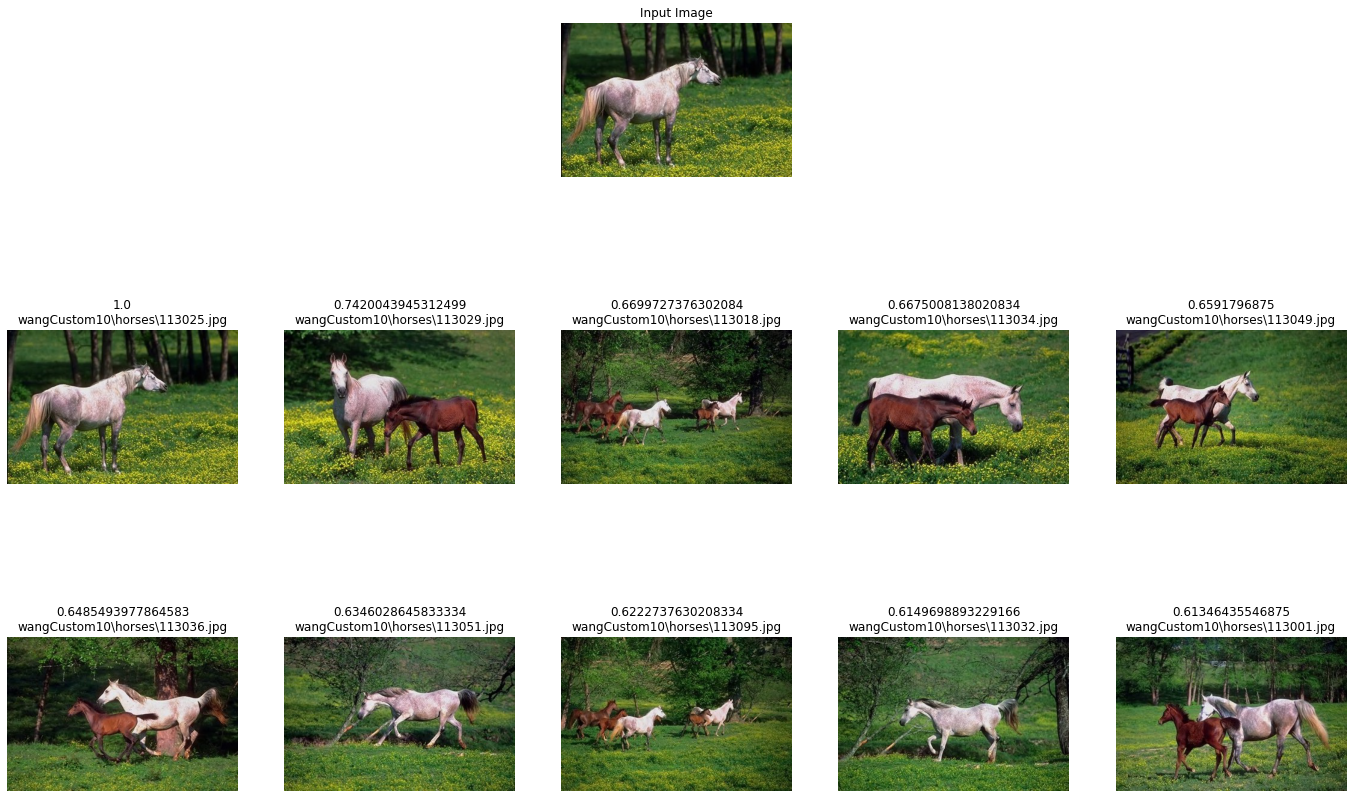

In [33]:
def display_image_search_result(result: dict):
    ''' Draws A Plot To Display A Search Result '''
    resultLen = len(result["Results"])
    # Berechne die Größe der Grafik
    figureHeight = math.ceil(resultLen / 5) * 8
    numOfRows = 1 + math.ceil(resultLen / 5)
    
    fig = plt.figure(figsize=(24, figureHeight))
    fig.patch.set_facecolor('white')

    fig.add_subplot(numOfRows, 5, 3)
    plt.imshow(get_image_data(result["Input"]))
    plt.title('Input Image')
    plt.axis('off')

    for i in range(0, resultLen):
        data = result["Results"][i]
        fig.add_subplot(numOfRows, 5, 6 + i)
        plt.imshow(get_image_data(data["Path"]))
        plt.title(str(data["Result"]) + "\n" + data["Path"])
        plt.axis('off')

    plt.show() 
    
display_image_search_result(search_imge(get_all_files("wangCustom10")[625], dbData))

Experimentieren Sie! Wann funktioniert die Bildsuche mit Farbhistogrammen gut, wann nicht?

#### Metriken

##### Accuracy
Die Accuracy beschreibt prozentual, wie viele der Vorhersagen korrekte Vorhersagen waren. In unserem Fall entspricht eine Accuracy von 10% raten, da wir 10 verschiedene Kategorien haben. Je unausgeglichener die Klassen verteilt sind, umso weniger aussagekräftig ist die accuracy. Im extrem Beispiel ist eine von hundert E-Mails eine Spam-Mail und eine KI die kein einziges Mal eine Spam-Mail vorhersagt, erreicht eine accuracy von 99%.

Deswegen wird beim Bewerten von Klassifizieren die Vorhersagen in vier verschiedene Bereiche unterteilt: True-Positive, True-Negative, False-Positive, False-Negative.

Dabei wird nicht nur unterschieden, ob eine Vorhersage richtig war oder nicht, sondern auch was hätte vorhergesagt werden sollen und was nicht. Daraus ergeben sich zwei Metriken: Recall und Precision.

##### Recall
Bei Recall wird die Menge der True-Positives durch die Summe der True-Positives und False-Negatives geteilt. In unserem Fall wird berechnet, wie viel Prozent der Pferde als Pferde erkannt wurden. 

##### Precision
Precision teilt die Menge der True-Positives durch die Summe der True-Positives und False-Positives. In unserem Fall wird berechnet, wie viel Prozent der Pferde vorhersagen tatsächlich Pferde waren.

##### F-Score
Der F-Score ist das harmonische Mittel aus Precision und Recall. Er wird häufig als zusammenfassende Metrik verwendet. 

In [50]:
def get_metrics(dbData: dict, search_function, print_metrics=True) -> list:
    ''' Calculates Some Metrecies Of A Search Function'''
    categories_list = dbData["Categories"].keys()
    
    result_list = []
    
    for category in categories_list:
        correct_values = 0
        total = 0
        y_true = []
        y_pred = []
        for search_image in dbData["Images"]:
            if(search_image["Category"] == category):
                result = search_function(search_image["Path"], dbData, 10)
                for res in result["Results"]:
                    if res["Category"] == category:
                        correct_values = correct_values + 1
                        y_pred.append(1)
                    else:
                        y_pred.append(0)
                        
                    total = total + 1
                    # Im Idealfall würden die ersten X Bilder immer der selben Kategorie angehören
                    # Und alle folgenden Bilder einer anderen Kategorie, da es nur X Bilder innerhalb
                    # einer Kategorie gibt
                    if(len(y_true) < dbData["Categories"][category]):
                        y_true.append(1)
                    else:
                        y_true.append(0)
        
        accuracy = correct_values / total
        precision, recall, fScore, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)
        
        result_list.append({"Name": category, "Accuracy": accuracy, "Recall": recall[1], "Precision": precision[1], "F-Score": fScore[1]})
        
        if print_metrics:
            print(category,"Total:", total, "\tCorrect:", correct_values, " Accuracy: ", (int)((accuracy) * 100), "% Recall:",recall[1], " Precision:",precision[1], " F-Score:", fScore[1])
        
    return result_list
        
# metrics = get_metrics(dbData, search_imge)

In [35]:
def draw_plot_from_metrics(metrics: list, compareWith:list=None, title:str="") -> None:

    labels = []
    recall = []
    precision = []
    accuracy = []
    f_score = []
    
    for metric in metrics: 
        labels.append(metric["Name"])
        recall.append(metric["Recall"])
        precision.append(metric["Precision"])
        f_score.append(metric["F-Score"])
        accuracy.append(metric["Accuracy"])
        
    if compareWith != None:
        
        if len(metrics) != len(compareWith):
            raise ValueError()
        
        other_recall = []
        other_precision = []
        other_accuracy = []
        other_f_score = []
        
        for metric in compareWith: 
            other_recall.append(metric["Recall"])
            other_precision.append(metric["Precision"])
            other_f_score.append(metric["F-Score"])
            other_accuracy.append(metric["Accuracy"])
            
        recall = np.subtract(np.array(recall), np.array(other_recall))
        precision = np.subtract(np.array(precision), np.array(other_precision))
        accuracy = np.subtract(np.array(accuracy), np.array(other_accuracy))
        f_score = np.subtract(np.array(f_score), np.array(other_f_score))
    
    fig, ax = plt.subplots(figsize=(24, 8))
    fig.patch.set_facecolor('white')
    
    width = 0.2
    x_axis = np.arange(len(labels))
    
    ax.bar(x_axis - width * 3/2, accuracy, width=width, label="Accuracy")
    ax.bar(x_axis - width/2, recall, width=width, label="Recall")
    plt.bar(x_axis + width/2, precision, width=width, label="Precision")
    plt.bar(x_axis + width * 3/2, f_score, width=width, label="F-Score")
    
    ax.set_title(title)
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Score')
    
    ax.xaxis.grid(True, which="minor")
    
    ax.yaxis.grid()
    
    if compareWith == None:
        ax.set_yticks(np.arange(0, 1.05, 0.05))
    else:
        array = [recall, precision, accuracy, f_score]
        min = np.amin(np.array(array), axis=0).min()
        max = np.amax(np.array(array), axis=0).max()
        ax.set_yticks(np.arange(min, max+0.005, 0.005))

    ax.legend()
    
    plt.show()
    
    
# draw_plot_from_metrics(metrics, "Search Metrics")

### Textur

Es wird local_binary_pattern für die Textur verwendet.
Dazu werden 5 Bildausschnitte untersucht. Die Bildausschnitte wurden nach der "[Rule Of Thirds](https://de.wikipedia.org/wiki/Drittel-Regel)" und dem Bildmittelpunkt bestimmt.
Dadurch, dass nur 5 Bildausschnitte der größe 32x32 berechnet werden, sind die Daten klein genug um sie in der Datenbank zu speichern.

In [36]:
def get_absolute_positions(image, relative_pos: list):
    '''Calculates The Absolute Positions From A List Of Tuples Containing Relative Positions (Between 0 und 1)'''
    image_size= np.subtract(get_image_data(image).shape[0:2], 32)
    locations = []
    
    for pos in relative_pos:
        locations.append(np.multiply(image_size, pos).astype(int))
        
    return locations

In [37]:
def get_patches(image, position: list, patch_size: int = 32):
    '''Returns a List Of Patches Of A Image. For Each Given Position A Pach Is Calculated.'''
    image = util.img_as_ubyte(rgb2gray(get_image_data(image)))

    locations = position
    patches = []
    
    for loc in locations:
        patches.append(image[loc[0]:loc[0] + patch_size,
                                loc[1]:loc[1] + patch_size])
        
    return patches

In [38]:
def draw_patches_in_image(image, position: list, patch_size: int = 32):
    '''A Util Function To Display Where The Patches Are On A Given Image'''
    _, ax = plt.subplots()
    ax.imshow(get_image_data(image))
    for (y, x) in position:
        rect = plt.Rectangle((x, y), patch_size, patch_size, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.plot(x + patch_size / 2, y + patch_size / 2, 'rs', label=str(x))
    
    plt.show()

#image = get_image_data(get_all_files("wangCustom10")[625])
#positions = get_absolute_positions(image, [(0.5, 0.5), (0.2, 0.2), (0.2, 0.8), (0.8, 0.2), (0.8, 0.8)])  
#patches = get_patches(image, positions)
#draw_patches_in_image(image, positions)

In [39]:
def calculate_histogram_from_patches(patches: list):
    '''Calculates The Local Binary Pattern On A List Of Patches And Returns A 1D Histogram'''
    input_bi_histogram = []
    for patch in patches:
        input_bi_histogram.append(skimage.feature.local_binary_pattern(patch, 24, 3, 'uniform'))
        
    input_bi_histogram = np.array(input_bi_histogram).flatten()
    input_bi_histogram = input_bi_histogram / np.sum(input_bi_histogram)
    return input_bi_histogram

#### Datenbank erstellung - ACHTUNG!!

Der Befehl 

    create_image_feature_db_with_texture("wangCustom10", os.path.join(".","featureDb.json"))

erstellt eine ca. 150MB große Datenbank MIT TEXTUREN! # Entfernen wenn Datenbank erstellt werden soll.
Datenbank MIT TEXTUREN ist notwendig für die nächsten Zellen.

In [42]:
def create_image_feature_db_with_texture(imageDirName: str, dbPathName: str) -> None:
    ''' Creates A JSON File Containing All Data And Texture Features About The Images Inside imageDirName '''
    jsonList = {"Categories":{}, "Images":[]}
    categoryList = []
    for file in get_all_files(imageDirName):
        cat:str = file.split(os.path.sep)[-2]
        name:str = file.split(os.path.sep)[-1]
        
        image_to_save = get_image_data(file)
        positions = [(0.5, 0.5), (0.2, 0.2), (0.2, 0.8), (0.8, 0.2), (0.8, 0.8)]
        
        patches = get_patches(image_to_save, get_absolute_positions(image_to_save, positions))
        
        image_set = {
            "Path": file, "Category": cat, "Filename": name, "Histogram": calculate_histogram_from_image(image_to_save).tolist(),
            "BinaryPattern": calculate_histogram_from_patches(patches).tolist()
            }
        jsonList["Images"].append(image_set)
        
        if cat in jsonList["Categories"].keys():
            counter = jsonList["Categories"][cat]
            jsonList["Categories"][cat] = counter + 1
        else:
            jsonList["Categories"][cat] = 1
            
    
    with open(dbPathName, "w", encoding='utf-8') as file:
        json.dump(jsonList, file, separators=(',', ':'), indent=2)
    
# create_image_feature_db_with_texture("wangCustom10", os.path.join(".","featureDb.json"))

In [43]:
def load_feature_db_with_textures(fileName: str) -> dict:
    ''' Reads A Generated JSON File And Returns A Dict Containing All Data And Texture Features'''
    with open(fileName, "r", encoding='utf-8') as file:
        jsonData = json.load(file)
        for data in jsonData["Images"]:
            data["Histogram"] = np.array(data["Histogram"])
            data["BinaryPattern"] = np.array(data["BinaryPattern"])
            
        return jsonData
    
dbData = load_feature_db_with_textures(os.path.join(".","featureDb.json"))

In [44]:
def find_image_in_database(image_path: str, db_data):
    '''Returns The Database Entry Of A Image To Save Some Calculation Time'''
    database = get_database_data(db_data)
    for image in database["Images"]:
        if image["Path"] == image_path:
            return image

In [45]:
def search_imge_with_texture(image: any, db_data: any, result_size: int = 10):
    ''' Searches For A Image Using Histogram Intersection And Local Binary Pattern. '''
    database = get_database_data(db_data)

    if isinstance(image, str):
        input_image = find_image_in_database(image, database)
        image_data = get_image_data(image)
    else:
        input_image = image
        image_data = image
    
    
    positions = [(0.5, 0.5), (0.2, 0.2), (0.2, 0.8), (0.8, 0.2), (0.8, 0.8)]
    all_results = {"Input": image_data, "Results": []}
    
    if isinstance(image, str):
        searched_histo = input_image["Histogram"]
        input_bi_histogram = input_image["BinaryPattern"]
    else:
        searched_histo = calculate_histogram_from_image(input_image)
        patches = get_patches(image, get_absolute_positions(image, positions))
        input_bi_histogram = calculate_histogram_from_patches(patches)
    
    for data in database["Images"]:
        bi_histogramm = data["BinaryPattern"] 
        
        histogramm_result = histogram_intersection(searched_histo, data["Histogram"])
        bi_histogram_result = histogram_intersection(input_bi_histogram, bi_histogramm)
        
        result = (histogramm_result + bi_histogram_result) / 2
        
        data_set = {"Path": data["Path"], "Category": data["Category"], "Filename": data["Filename"], "Result": result}
        all_results["Results"].append(data_set)
        
    def sort_by_result(e: dict):
        return e["Result"]
    
    all_results["Results"].sort(reverse=True, key=sort_by_result)
    all_results["Results"] = all_results["Results"][0:result_size]
    return all_results

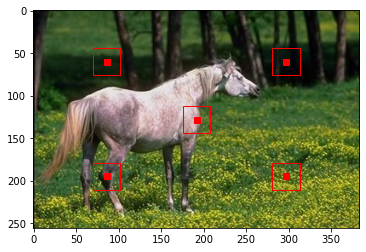

In [46]:
draw_patches_in_image(
    get_all_files("wangCustom10")[625],
    get_absolute_positions(
        get_all_files("wangCustom10")[625],
        [(0.5, 0.5), (0.2, 0.2), (0.2, 0.8), (0.8, 0.2), (0.8, 0.8)]
    )
)

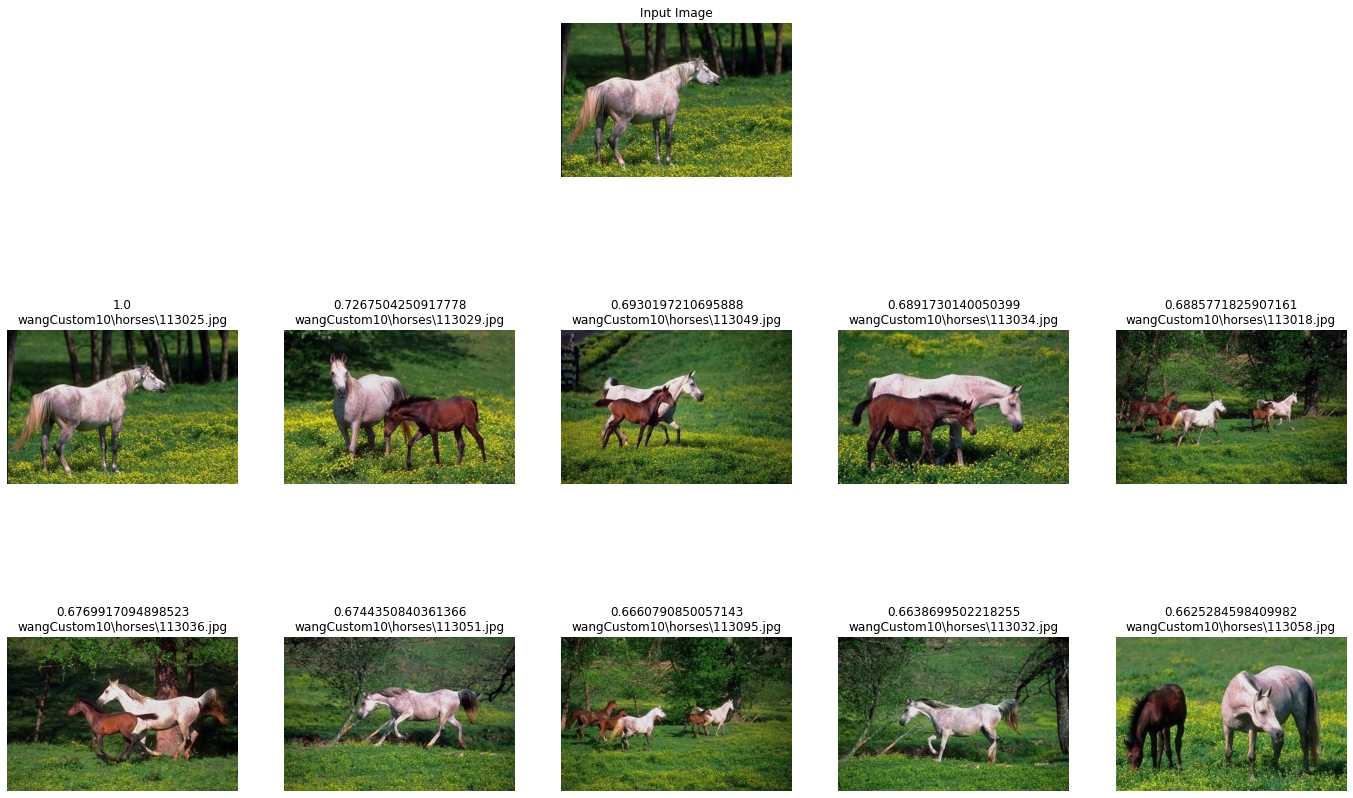

In [47]:
display_image_search_result(search_imge_with_texture(get_all_files("wangCustom10")[625], dbData))

#### Ergebnis

Normal Search:
alaska Total: 1000 	Correct: 828  Accuracy:  82 % Recall: 0.94  Precision: 0.11352657004830918  F-Score: 0.2025862068965517
antiques Total: 1000 	Correct: 906  Accuracy:  90 % Recall: 0.85  Precision: 0.09381898454746136  F-Score: 0.16898608349900593
balloon Total: 1000 	Correct: 594  Accuracy:  59 % Recall: 0.61  Precision: 0.1026936026936027  F-Score: 0.17579250720461093
cats Total: 1000 	Correct: 595  Accuracy:  59 % Recall: 0.6  Precision: 0.10084033613445378  F-Score: 0.17266187050359713
crystal Total: 1000 	Correct: 801  Accuracy:  80 % Recall: 0.96  Precision: 0.1198501872659176  F-Score: 0.21309655937846833
elephants Total: 1000 	Correct: 821  Accuracy:  82 % Recall: 0.74  Precision: 0.09013398294762484  F-Score: 0.16069489685124863
horses Total: 1000 	Correct: 965  Accuracy:  96 % Recall: 0.95  Precision: 0.09844559585492228  F-Score: 0.17840375586854462
mushroom Total: 1000 	Correct: 672  Accuracy:  67 % Recall: 0.63  Precision: 0.09375  F-Score: 0.163212435233

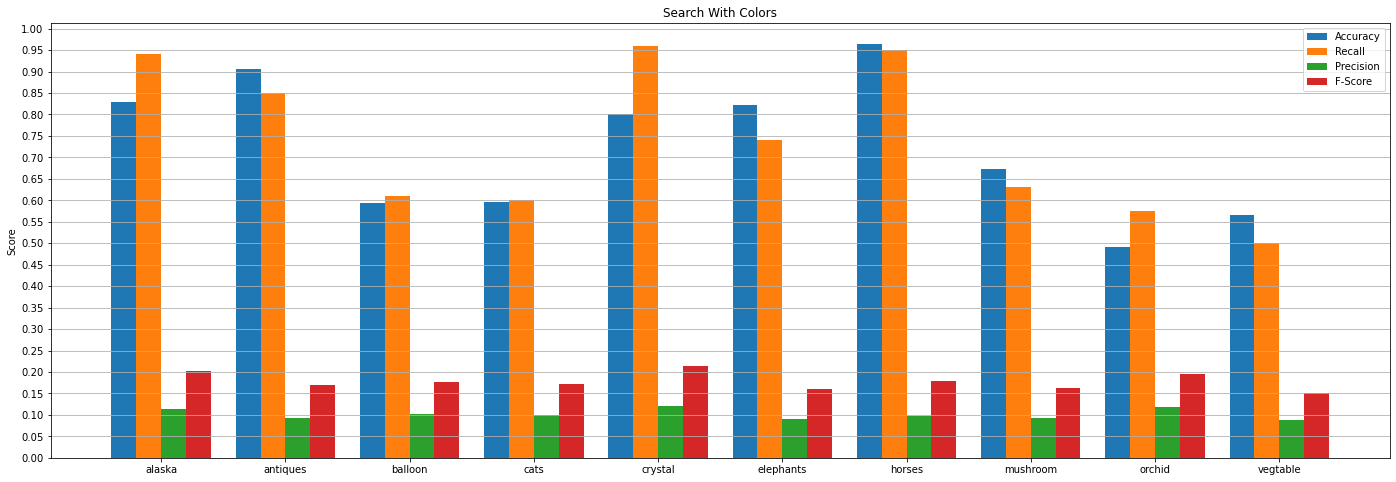

Texture Search:
alaska Total: 1000 	Correct: 858  Accuracy:  85 % Recall: 0.95  Precision: 0.11072261072261072  F-Score: 0.19832985386221294
antiques Total: 1000 	Correct: 917  Accuracy:  91 % Recall: 0.85  Precision: 0.09269356597600872  F-Score: 0.1671583087512291
balloon Total: 1000 	Correct: 609  Accuracy:  60 % Recall: 0.6  Precision: 0.09852216748768473  F-Score: 0.1692524682651622
cats Total: 1000 	Correct: 576  Accuracy:  57 % Recall: 0.58  Precision: 0.10069444444444445  F-Score: 0.1715976331360947
crystal Total: 1000 	Correct: 821  Accuracy:  82 % Recall: 0.96  Precision: 0.11693057247259439  F-Score: 0.20846905537459282
elephants Total: 1000 	Correct: 827  Accuracy:  82 % Recall: 0.76  Precision: 0.09189842805320435  F-Score: 0.16396979503775622
horses Total: 1000 	Correct: 974  Accuracy:  97 % Recall: 0.97  Precision: 0.09958932238193019  F-Score: 0.18063314711359404
mushroom Total: 1000 	Correct: 666  Accuracy:  66 % Recall: 0.61  Precision: 0.0915915915915916  F-Score: 0.

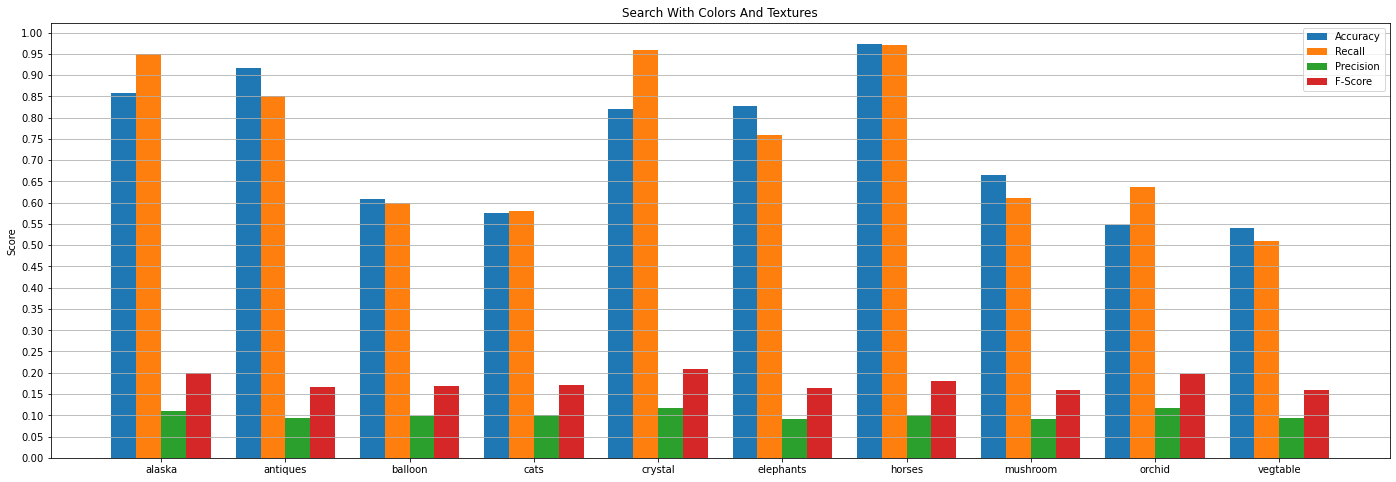

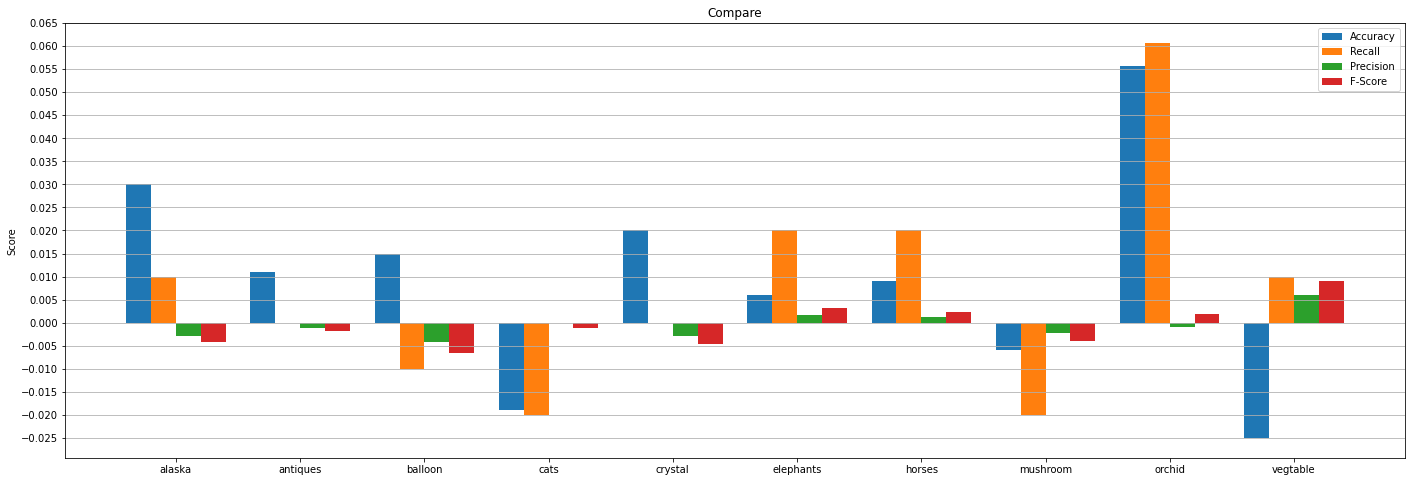

In [51]:
print("Normal Search:")
normal_metric = get_metrics(dbData, search_imge)
draw_plot_from_metrics(normal_metric, title="Search With Colors")

print("Texture Search:")
texture_metric = get_metrics(dbData, search_imge_with_texture)
draw_plot_from_metrics(texture_metric, title="Search With Colors And Textures")

draw_plot_from_metrics(texture_metric, compareWith=normal_metric, title="Compare")